# Building alternative pipeline

* Prepare Hough transform based only on wire information (= energy, time, radial distance)
* Build predictions based on Hough, local information, and local information of left/right neighbors


In [242]:
%run visualizations.ipynb
import sys
sys.path.insert(0, '../modules')

Populating the interactive namespace from numpy and matplotlib


In [2]:
from hits import AllHits
hits = AllHits('../data/signal_TDR.root')

In [3]:
import pandas
from tracking import Hough
from scipy import sparse
from sklearn.metrics import roc_auc_score, roc_curve

### Collect (Raw) Wire Features 

In [4]:
right_neighs = numpy.array([hits.cydet.shift_wire(wire, 1) for wire in range(hits.cydet.n_points)])
left_neighs = numpy.array([hits.cydet.shift_wire(wire, -1) for wire in range(hits.cydet.n_points)])

In [5]:
# Energy deposits
deposits = numpy.vstack(hits.get_energy_deposits(i) for i in range(hits.n_events))
deposits *= 100 # to avoid small numbers for GBRT
# Time after triggering that signal waveforms starts
rel_time = numpy.vstack(hits.get_relative_time(i) for i in range(hits.n_events))
# Truth Values
labels = numpy.vstack(hits.get_hit_types(i) for i in range(hits.n_events))
# Layer ID of hit wires
layer_id = numpy.vstack(hits.cydet.point_rhos for i in range(hits.n_events))

In [6]:
labels.shape, deposits.shape

((3445, 4482), (3445, 4482))

## Convenience Functions for Data

In [7]:
def flatten_data(data, keys, samples, n_features):
    data_flat = data[samples].reshape(-1, n_feats)
    return pandas.DataFrame(data=data_flat, columns=keys)

def mask(data, pol=None):
    if pol==None:
        return data[data['labels'] != 0]
    if pol==0:
        return data[(data['labels'] != 0) & (data['Polarity'] == 0)]
    if pol==1:
        return data[(data['labels'] != 0) & (data['Polarity'] != 0)]

def predict_classifier(classifier, data_samp):
    """
    Return predictions where no hit has zero response by definition.  Return both
    flat predictions, and event sorted predicitions
    """
    # Get the predictions
    pred_evt = classifier.predict_proba(data_samp)[:,1]

    # Check which wires have hits, which ones do not
    not_hit = (data_samp['labels'] == 0).values
    has_hit = (data_samp['labels'] != 0).values

    # Define hit-less wires as definitely not being signal
    pred_evt[not_hit] = 0

    # Slim down the result to a copy with only hits
    pred = pred_evt[has_hit]
    # Reshape the result to be the event shape, for the hoguh transform
    pred_evt = pred_evt.reshape(-1, hits.cydet.n_points)
    
    return pred, pred_evt

In [8]:
## Look up table to map from events to hits
event_to_hit_look = np.arange(hits.n_events*hits.cydet.n_points).reshape(hits.n_events, -1)

## Train/test splitting 

In [9]:
from sklearn.cross_validation import train_test_split
rest, sample_3 = train_test_split(range(len(labels)), train_size=0.6, test_size=0.3)
sample_1, sample_2 = train_test_split(rest, train_size=0.5, test_size=0.5)

## Features for Wire GBDT

In [10]:
from collections import OrderedDict
features = OrderedDict()
# Wire features
features['deposit'] = deposits * 100
features['rel_time'] = rel_time
features['layer_id'] = layer_id

# LR-Neighbour Features
features['r_deposit'] = (deposits * 100)[:, right_neighs]
features['r_rel_time'] = rel_time[:, right_neighs]
features['l_deposit'] = (deposits * 100)[:, left_neighs]
features['l_rel_time'] = rel_time[:, left_neighs]

# Truth values
features['labels'] = labels
features['is_signal'] =  numpy.take([0, 1, 0], labels)

In [11]:
# Define Data
train_features = features.keys()[:-2]
data = numpy.dstack(features.values())
n_feats = data.shape[-1]
print data.shape

(3445, 4482, 9)


In [12]:
data_1, data_2, data_3 = [flatten_data(data, features.keys(), samp, n_feats) 
                          for samp in [sample_1, sample_2, sample_3]]

## NeighbourLevel GBDT

In [13]:
from rep.metaml.factory import ClassifiersFactory
from rep.estimators import SklearnClassifier, TMVAClassifier
from sklearn.ensemble import GradientBoostingClassifier
from rep.report.metrics import RocAuc

In [14]:
factory = ClassifiersFactory()

# Define GBDT over neighbour-level features
neigh_gbdt = SklearnClassifier(GradientBoostingClassifier(n_estimators=100), 
                                    features=train_features)
# Add the GBDT
factory.add_classifier('Local and Neighbour Features', neigh_gbdt)

In [15]:
# Train the classifier
factory.fit(mask(data_1), mask(data_1)['is_signal'])
pass

model Local and Neighbour Features was trained in 117.04 seconds
Totally spent 117.04 seconds on training


In [16]:
# Print these predictions
pred_2, pred_evt_2 = predict_classifier(neigh_gbdt, data_2)

## Testing hough  

In [17]:
# Define which wires we want to correct as hits which were missclassified 
problem_weights_2 = (mask(data_2)['labels'] != 0) * abs(mask(data_2)['is_signal'] - pred_2) ** 2

### Quality of classification, reweighted to highlight mislabelled hits
Second scoring is used later to measure quality of Hough transform

In [18]:
print roc_auc_score(mask(data_2)['is_signal'], pred_2)
print roc_auc_score(mask(data_2)['is_signal'], pred_2, sample_weight=problem_weights_2)

0.996683025772
0.259307233877


### Define correspondence matrix separately for even/odd, use several radii

In [19]:
default = [[31.5, 34, 34.5, 2]]
submatrices = []

# Define even and odd layer wires
even_wires = hits.cydet.point_pol != 1
odd_wires = hits.cydet.point_pol == 1

# TODO test with several radii
for rmin, rmean, rmax, rsgma in default: #[[30, 33, 35], [26, 29, 32]]:
    # Try with default values
    hough = Hough(hits, sig_rho_min=rmin, sig_rho=rmean, sig_rho_max=rmax, sig_rho_sgma=rsgma)
    corresp = hough.correspondence
    
    # Make even and odd layer hough matricies
    corresp_odd = corresp.copy()
    corresp_odd[even_wires, :] = 0
    corresp_even = corresp.copy()
    corresp_even[odd_wires, :] = 0
    
    # Append the two matricies
    submatrices.append(corresp_odd)
    submatrices.append(corresp_even)

# Stack all submatricies horizontally
new_correspondence = sparse.hstack(submatrices)

In [20]:
# Check the shape, and the number of non-zero entries
new_correspondence.shape, new_correspondence.nnz

((4482, 5634), 264565)

In [21]:
def is_max(data, neighs_matrix, alpha=10):
    """
    This is soft version of 'is_max' rule.
    Strong version returns 1 it it is max among neighbors, 0 otherwise.
    The greater alpha, the closer we are to 'strong' version
    
    :param data:          Hough image(s) from transformation(s)
    :param neighs_matrix: Nearest neighbour matrix for hough track-centres
    :param alpha:         Weight of exponential reweighting 
    """
    # Exponentially reweight the data
    exponents = numpy.exp(alpha * data)
    # Check the number of maxima we expect to get back
    # Note, we expect two maxima for each tested hough transform
    # One for even, one for odd.  
    # Testing multiple transforms scales as 2*n_transforms
    n_parts = data.shape[1] // neighs_matrix.shape[1]
    assert n_parts * neighs_matrix.shape[1] == data.shape[1]
    # Block diagnol matrix, with each block being one copy of the neighs_matrix
    full_neigh = sparse.block_diag([neighs_matrix] * n_parts, format='csr')
    # Return the value at the point
    # normalized the sum of its values and its neighbouring values
    return exponents / full_neigh.dot(exponents.T).T

In [22]:
# Normalized nearest neighbors matrix for tracks
## Pick out the neighbours
nns = hough.track.point_neighbours
## Add a track centre as its own neighbour
nns = nns + sparse.identity(nns.shape[1])
## Extend the neighbours out one to the left and one to the right
## Now a 3x5 block
nns = nns.dot(hough.track.lr_neighbours)
## Weight the closer neighbours as double the further onesca
nns += hough.track.lr_neighbours 
## Normalize 
nns = sparse.csr_matrix(nns / nns.sum(axis=1))

### Since hough has some parameters,  those should be fitted on train data

In [427]:
class HoughTransform(object):
    def __init__(self, hough_matrix, track_nns, min_percentile=0.97, alpha_rw=2, alpha_max=2):
        """
        Define a hough transform class that we can fit to the data
        
        :param hough_matrix:    Hough transform matrix
        :param track_neighs:    Nearest neighbour matrix for tracks
        :param min_percentile:  Bottom percentile ignored in hough space 
        :param alpha_rw:        Weight of reweight in hough space
        :param alpha_max:       Weight of peak reweight in hough space
        """
        self.hough_matrix = hough_matrix
        self.min_percentile = min_percentile
        self.alpha_rw = alpha_rw
        self.alpha_max = alpha_max
        # Normalize the hough transform so to decrease bias towards track-centre layers 
        # with better coverage, i.e. more wires in range
        self.normed_corresp = sparse.csr_matrix(hough_matrix / (hough_matrix.sum(axis=1) + 50.))
        self.track_nns = track_nns
        
    def fit(self, X):
        """
        Fit the hough transform to the data
        
        :param X: Data to be fit
        """
        #self.n_features = X.shape[1]
        
        # Center the input distribution around 0
        self.original_mean = X.mean()
        original = X - self.original_mean

        # Transform into hough space
        hough_images = self.normed_corresp.T.dot(original.T).T
        
        # Use a percentile binning with increased sampling near 1
        x = numpy.linspace(0, 1, 200) ** 0.5
        # Get the percentile distribution
        self.percentiles = numpy.percentile(hough_images.flatten(), x * 100)
        # Remove the bottom min_percentile and shift the remaining range to fit in [0-1]
        self.values_at_percentiles = numpy.maximum(0., x - self.min_percentile) / (1. - self.min_percentile)
        hough_images = numpy.interp(hough_images, self.percentiles, self.values_at_percentiles)
        
        # Sharpen locally maximum peaks
        hough_images = hough_images * is_max(hough_images, neighs_matrix=self.track_nns, alpha=self.alpha_max)
        # Exponentiate the 
        hough_images = numpy.exp(self.alpha_rw * hough_images)
        self.mean_hough = hough_images.mean()
        
        return self
    
    def transform(self, X):
        """
        Transform the data according to the fit
        
        :param X: Data to be transformed
        
        :return after_hough, hough_images: ???
        """
        # Center the input distribution around 0
        original = X - self.original_mean
        
        # Perform the hough transform
        hough_images = self.normed_corresp.T.dot(original.T).T
        # Remove the bottom min_percentile and shift the remaining range to fit in [0-1]
        hough_images = numpy.interp(hough_images, self.percentiles, self.values_at_percentiles)        
        
        # Reweight hough images by how locally maximal each point is
        hough_images = hough_images * is_max(hough_images, neighs_matrix=self.track_nns, alpha=self.alpha_max)
        # Reweight result exponentially
        hough_images = numpy.exp(self.alpha_rw * hough_images)
        # Center around 0
        hough_images -= self.mean_hough
        
        # Inverse hough transform
        after_hough = self.normed_corresp.dot(hough_images.T).T
        
        return after_hough, hough_images

## Traning second classifier

In [24]:
# Fit and transform the second data sample
hough_transformer = HoughTransform(hough_matrix=new_correspondence, track_nns=nns)
hough_transformer.fit(pred_evt_2)

In [25]:
pred_3, pred_evt_3 = predict_classifier(neigh_gbdt, data_3)

# Get the hough results
hough_result_2, hough_image_2 = hough_transformer.transform(pred_evt_2)
hough_result_3, hough_image_3 = hough_transformer.transform(pred_evt_3)

# Add these as features
data_2['Hough'] = hough_result_2.flatten()
data_3['Hough'] = hough_result_3.flatten()

In [26]:
# Add this to the feature list
train_features_full = train_features + ['Hough']

# Define the new classifier
hough_gbdt = SklearnClassifier(GradientBoostingClassifier(n_estimators=100), 
                               features=train_features_full) 

# Define GBDT over only energy deposit to compare
dep_gbdt = SklearnClassifier(GradientBoostingClassifier(n_estimators=200), 
                               features=['deposit'])

# Ensure neigh-level GBDT has enough trees to compare properly
neigh_gbdt.set_params(n_estimators=200)

# Add the classifiers
factory.add_classifier('Hough, Local and Neighbour Features', hough_gbdt)
factory.add_classifier('Energy Deposition', dep_gbdt)

In [27]:
# Train the classifier
factory.fit(mask(data_2), mask(data_2)['is_signal'])
pass

model Local and Neighbour Features was trained in 231.16 seconds
model Hough, Local and Neighbour Features was trained in 124.51 seconds
model Energy Deposition was trained in 62.03 seconds
Totally spent 417.70 seconds on training


In [59]:
# Test it on the last set of data
pred_final_diag_3 = factory.test_on(mask(data_3), mask(data_3)['is_signal'])
pred_final_3, pred_final_evt_3 = predict_classifier(hough_gbdt, data_3)
pred_3, pred_evt_3 = predict_classifier(neigh_gbdt, data_3)

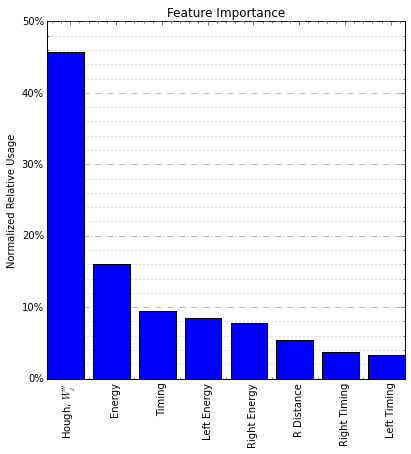

/home/elg112/.local/lib/python2.7/site-packages/matplotlib/axes/_axes.py:475: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


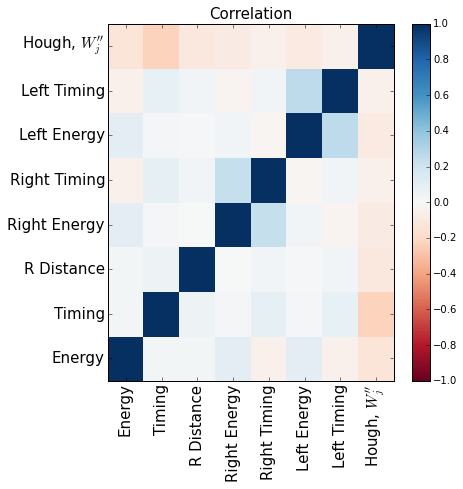

In [29]:
figsize(6.4,6.4) 
hough_level = factory["Hough, Local and Neighbour Features"]
feat_import = hough_level.get_feature_importances()
feat_import = feat_import.sort("effect", ascending=False)
feat_label_dict = OrderedDict([
        ('l_rel_time' , "Left Timing"),  
        ('r_rel_time' , "Right Timing"),
        ("layer_id" , "R Distance"), 
        ('r_deposit' , 'Right Energy'), 
        ('l_deposit' , 'Left Energy'), 
        ('rel_time' , "Timing"),
        ('deposit' , 'Energy'), 
        ('Hough' , r"Hough, $W_j''$")
    ])
ax = plt.subplot(111)
ax.bar( np.arange(len(feat_import.values)), feat_import.values,zorder=10)
ax.set_xticks(np.arange(len(feat_import.values))+0.5)
ax.minorticks_on()
ax.set_ylabel("Normalized Relative Usage")
ax.set_title("Feature Importance")
ax.autoscale()

ax.grid(b=True, which='major', axis='y' ,color='grey', linestyle='--')
ax.grid(b=True, which='minor', axis='y' , color='grey', linestyle=':')
ax.set_xticklabels(feat_label_dict.values()[::-1],  rotation='vertical')
ax.set_yticklabels(["{:.0f}%".format(tick*100) for tick in ax.get_yticks()])

show()

corr = pred_final_diag_3.features_correlation_matrix(features=train_features+["Hough"],
                            tick_labels=[feat_label_dict[key] for key in train_features_full])
corr.fontsize = 15
corr.cmap = "RdBu"
corr.plot()


(<matplotlib.axes._subplots.AxesSubplot at 0x25a45090>,
 <matplotlib.figure.Figure at 0x25a28a10>)

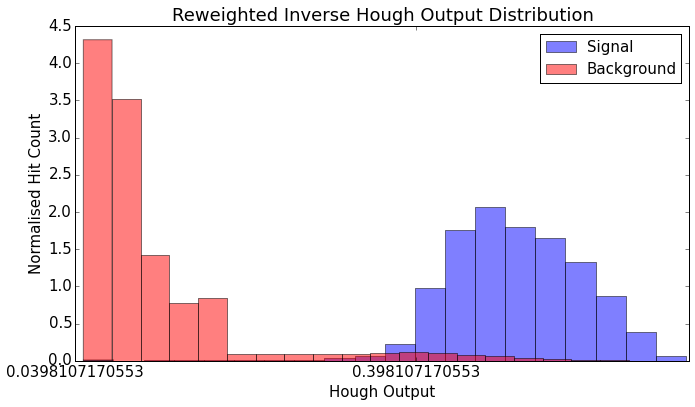

In [56]:
plot_feature( (data_3['Hough'].values+0.1), data_3['labels'].values, 
             xlabel="Hough Output", ylabel="Normalised Hit Count", xlog=True,
            title="Reweighted Inverse Hough Output Distribution", nbins=20)


## Final quality of signal vs bck wires

0.999301693494


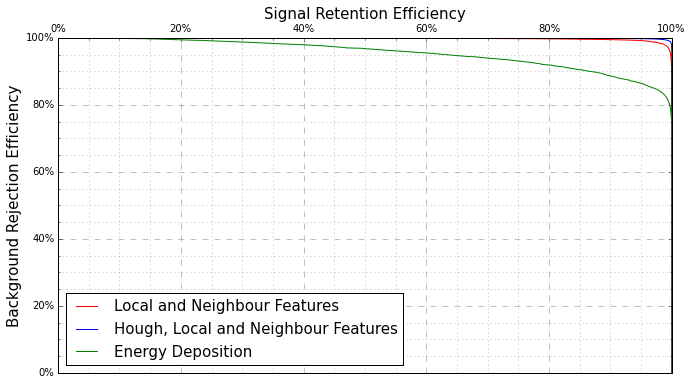

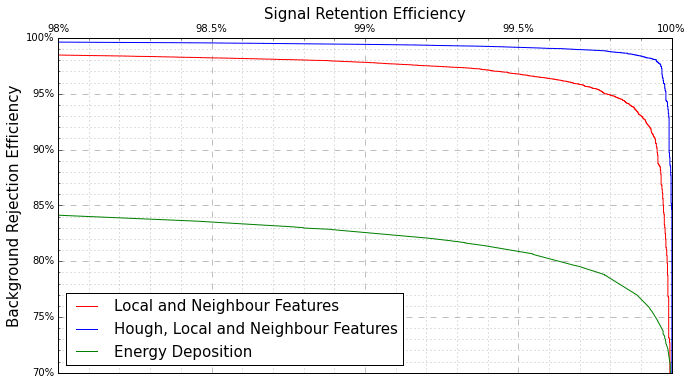

In [31]:
print roc_auc_score(mask(data_3)['is_signal'], pred_final_3)
figsize(11,6) 
plot_rocs(mask(data_3)["is_signal"], pred_final_diag_3.prediction, zoom=False)
plt.savefig("/home/elg112/COMET/Presentations_Papers/group_meetings/images/tmva_roc.png", bbox_inches="tight")
show()
plot_rocs(mask(data_3)["is_signal"], pred_final_diag_3.prediction, zoom=True)
plt.savefig("/home/elg112/COMET/Presentations_Papers/group_meetings/images/tmva_roc_zoom.png", bbox_inches="tight")
show()

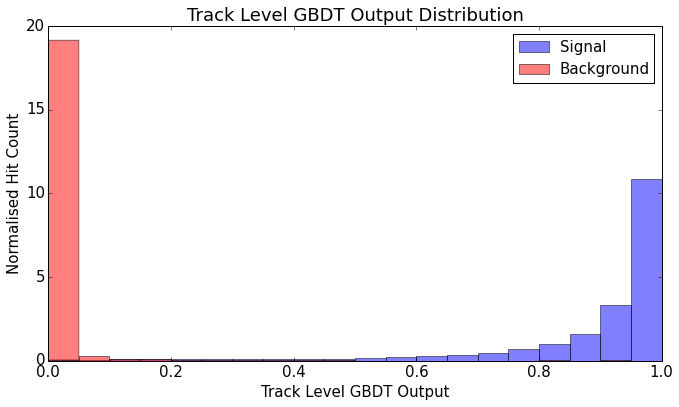

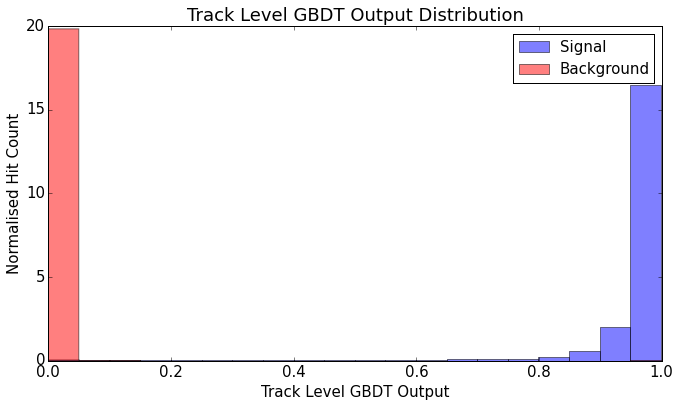

In [61]:
plot_feature( pred_3, mask(data_3)['labels'].values, 
             xlabel="Track Level GBDT Output", ylabel="Normalised Hit Count", 
            title="Track Level GBDT Output Distribution", nbins=20)
show()
plot_feature( pred_final_3, mask(data_3)['labels'].values, 
             xlabel="Track Level GBDT Output", ylabel="Normalised Hit Count",
            title="Track Level GBDT Output Distribution", nbins=20)
show()

In [62]:
problem_weights_3 = (mask(data_3)['labels'] != 0) * abs(mask(data_3)['is_signal'] - pred_3) ** 2
print roc_auc_score(mask(data_3)['is_signal'], pred_3)
print roc_auc_score(mask(data_3)['is_signal'], pred_3, sample_weight=problem_weights_3)

0.997883248795
0.216075058449


In [63]:
problem_weights_3 = (mask(data_3)['labels'] != 0) * abs(mask(data_3)['is_signal'] - pred_final_3) ** 2
print roc_auc_score(mask(data_3)['is_signal'], pred_final_3)
print roc_auc_score(mask(data_3)['is_signal'], pred_final_3, sample_weight=problem_weights_3)

0.999301693494
0.120361126203


##RANSAC Implimentation

In [69]:
from sklearn import linear_model
#print linear_model.LinearRegression__doc__
#print linear_model.RANSACRegressor.__doc__

In [66]:
# Get the actual circle parameters for the fit from the linearized parameters
def get_circle(x_coeff, y_coeff, intercept):
    return x_coeff/2, y_coeff/2, np.sqrt(4*intercept + x_coeff**2 + y_coeff**2)/2

In [67]:
# Check that the fit returns a circle that passes through the production target
def inside_target(model, X, y):
    a, b, r = get_circle(model.coef_[0][0], model.coef_[0][1], model.intercept_)
    return abs(np.sqrt(a**2 + b**2) - r) < 10

In [70]:
# GBDT likes these data points 
#def good_points(X, y):
#    a, b, r = get_circle(model.coef_[0][0], model.coef_[0][1], model.intercept_)
#    return abs(np.sqrt(a**2 + b**2) - r) < 10

In [213]:
# Geometric considerations for the fit
wire_x, wire_y = hits.cydet.get_points_xs_and_ys()
# Linearize the input problem
wire_xy = np.vstack([wire_x, wire_y]).T
wire_z  = np.square(wire_x) + np.square(wire_y)
        
def ransac_fit(labels, preds, min_hits=13, plot=False):
    # Initialze parameters
    x1, y1, r1 = -1.*np.zeros(2), -1.*np.zeros(2), -1.*np.zeros(2)
    x2, y2, r2 = -1.*np.zeros(2), -1.*np.zeros(2), -1.*np.zeros(2)
    this_score = -1.*np.ones(wire_z.shape[0])
    
    # Get wires to fit
    even_sig = even_wires & preds
    odd_sig = odd_wires & preds
    
    # Plot the input to the fit
    if plot:
        plot_output(to_plot, hits.cydet, size=40*preds)
        plot_add_outlines(to_plot, hits.cydet)

    # Skip if either layer does not have enough hit points
    # if (sum(even_sig) < min_hits) or (sum(odd_sig) < min_hits):
    #     print "Skipped"
    #    if plot:
    #        show()
    #    return

    for pol, signal in enumerate([even_sig, odd_sig]):

        # Get the points to fit
        fit_x, fit_y = wire_x[signal], wire_y[signal]
        fit_xy = np.vstack([fit_x,fit_y]).T
        # Linearize the equation
        fit_z = np.square(fit_x) + np.square(fit_y)

        # Fit line using all data
        model = linear_model.LinearRegression()
        try:
            model.fit(fit_xy, fit_z)
        except ValueError:
            if plot:
                print "Skipped Normal"
                show()
            return x1, y1, r1, x2, y2, r2, this_score
        
        # Robustly fit linear model with RANSAC algorithm
        model_ransac = linear_model.RANSACRegressor(linear_model.LinearRegression(),
                                                   is_model_valid=inside_target,
                                                   max_trials=1000)
        try:
            model_ransac.fit(fit_xy, fit_z)
        except ValueError:
            if plot:
                print "Skipped RANSAC"
                show()
            return x1, y1, r1, x2, y2, r2, this_score
        
        inlier_mask = signal[model_ransac.inlier_mask_]
        outlier_mask = signal[np.logical_not(model_ransac.inlier_mask_)]

        # Plot the output
        labels = np.zeros(hits.cydet.n_points)
        labels[inlier_mask] = 1
        labels[outlier_mask] = 2

        # Get the regular fit
        x1[pol], y1[pol], r1[pol] = get_circle(model.coef_[0], model.coef_[1] , model.intercept_)

        # Get the RANSAC fit
        x2[pol], y2[pol], r2[pol] = get_circle(model_ransac.estimator_.coef_[0][0], 
                         model_ransac.estimator_.coef_[0][1] , model_ransac.estimator_.intercept_)

        # Make sure we're plotting all points
        assert len(inlier_mask) + len(outlier_mask) == sum(signal),\
            "{} {}".format(len(inlier_mask) + len(outlier_mask), len(signal))    
        if plot:
            plot_add_circle(x1[pol], y1[pol], r1[pol])
            print "Fit:" + str(r1[pol])
            plot_add_circle(x2[pol], y2[pol], r2[pol], color="red")
            print "RANSAC Fit:" + str(r2[pol]) + "\n"

        # Score the wires by distance from RANSAC
        this_score = model_ransac.estimator_.predict(wire_xy)[:,0]
        this_score -= wire_z
        this_score = np.absolute(this_score)
    if plot:
        show()
    return x1, y1, r1, x2, y2, r2, this_score

In [214]:
# Define threshold GBDT output to fit to
fpr, tpr, values =  roc_curve(mask(data_3)['is_signal'], pred_final_3)
threshold = np.where(tpr > 0.99)[0][0]
print "TPR: {}".format(tpr[threshold]),\
      "FPR: {}".format(fpr[threshold]),\
      "VALUE: {}".format(values[threshold])

# Define the wires to be fit and their locations
cut_pred_final_3 = pred_final_evt_3 > values[threshold]
fit_evts = cut_pred_final_3.shape[0]

TPR: 0.990001947673 FPR: 0.00570311558512 VALUE: 0.295407626419


In [215]:
# Score the wires by distance from RANSAC
score = np.zeros(data_3['labels'].shape[0]) 
for evt in range(len(sample_3)):
    if evt%100 == 0:
        print evt
    evt_hits = event_to_hit_look[evt]
    to_fit = data_3["labels"].values[evt_hits]
    output = ransac_fit(to_fit, cut_pred_final_3[evt,:])
    if output != None:
        score[evt_hits] =  output[-1]
data_3['score'] = score

0
100
200
300
400
500
600
700
800
900
1000


In [252]:
good_events = data_3[data_3['score'] != -1].shape[0]/4482
total_events = data_3.shape[0]/4482
print good_events/float(total_events)

0.949709864603
(683128,)


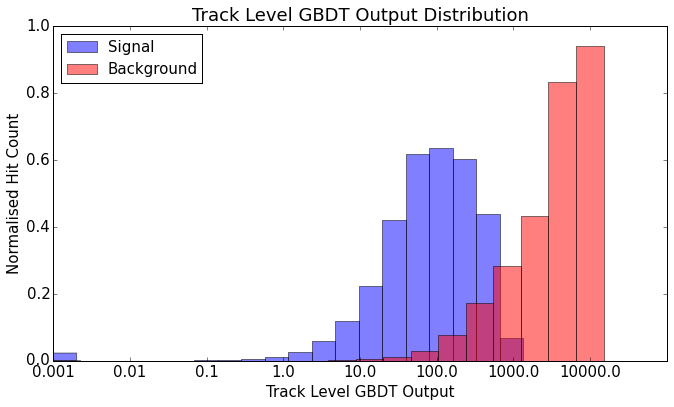

In [241]:
plot_feature((mask(data_3)[data_3['score'] != -1]['score'].values +0.001), 
             mask(data_3)[data_3['score'] != -1]['labels'].values, xlog=True,
             xlabel="Track Level GBDT Output", ylabel="Normalised Hit Count",
            title="Track Level GBDT Output Distribution", nbins=20)
show()

## Rotation of Even Layers from Hough Output

In [492]:
# Play with alpha values to find best alignment method
aligner = HoughTransform(hough_matrix=new_correspondence, track_nns=nns, alpha_rw=2, alpha_max=2)
aligner.fit(pred_evt_2)
_ , to_align = aligner.transform(pred_evt_3)

In [705]:
event = 39
evt_hits = event_to_hit_look[event]
to_plot = data_3["labels"].values[evt_hits]

In [706]:
# Get even and odd contributions
hough_image_even = to_align[event,:hough.track.n_points]
hough_image_odd = to_align[event,hough.track.n_points:]

In [707]:
# Initialize the realignment algorithm
n_phis = hough.track.n_by_layer[0]
dphi = 2*np.pi/n_phis
track_angles = hough.track.get_points_rhos_and_phis()[1]
all_slices = np.zeros((n_phis, hough.track.n_points))
integral_even = np.zeros(n_phis)
integral_odd = np.zeros(n_phis)

In [708]:
# Integrate over slices in phi
# TODO iterpolate in hough space first?
for phi_slice in range(n_phis):
    phi_0 = phi_slice*dphi
    phi_1 = phi_0 + dphi
    this_slice = np.where((track_angles > phi_0) & (track_angles < phi_1))
    all_slices[phi_slice, this_slice] = 1
    integral_even[phi_slice] = np.sum(hough_image_even[this_slice])
    integral_odd[phi_slice] = np.sum(hough_image_odd[this_slice])

In [709]:
difference = 1000000000
ideal_phi = -1

# Find the ideal shift in phi to align images in hough space
for phi_shift in range(n_phis):
    new_int_even = np.roll(integral_even, phi_shift)
    this_diff = np.sum(np.square(new_int_even - integral_odd))
    if this_diff < difference:
        difference = this_diff 
        ideal_phi = phi_shift
print ideal_phi

1


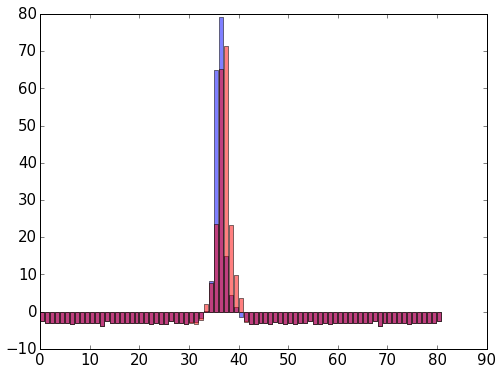

<Container object of 81 artists>

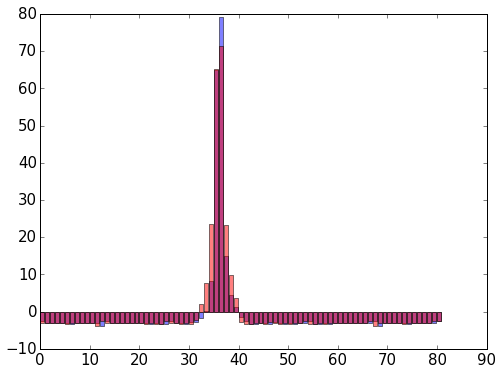

In [710]:
figsize(8,6)
plt.bar(range(len(integral_even)), integral_even, alpha=0.5)
plt.bar(np.arange(len(integral_even)), integral_odd, color="red",alpha=0.5)
show()
plt.bar(range(len(integral_even)), integral_even, alpha=0.5)
plt.bar(np.roll(np.arange(len(integral_even)), ideal_phi), integral_odd, color="red",alpha=0.5)

Length of draw tracks are 56


/home/elg112/.local/lib/python2.7/site-packages/IPython/kernel/__main__.py:13: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


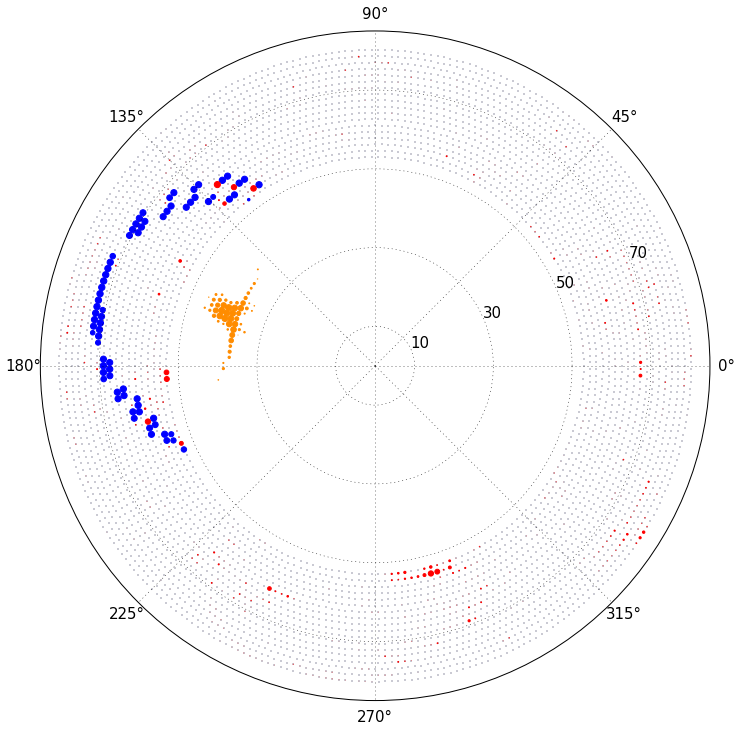

Length of draw tracks are 77


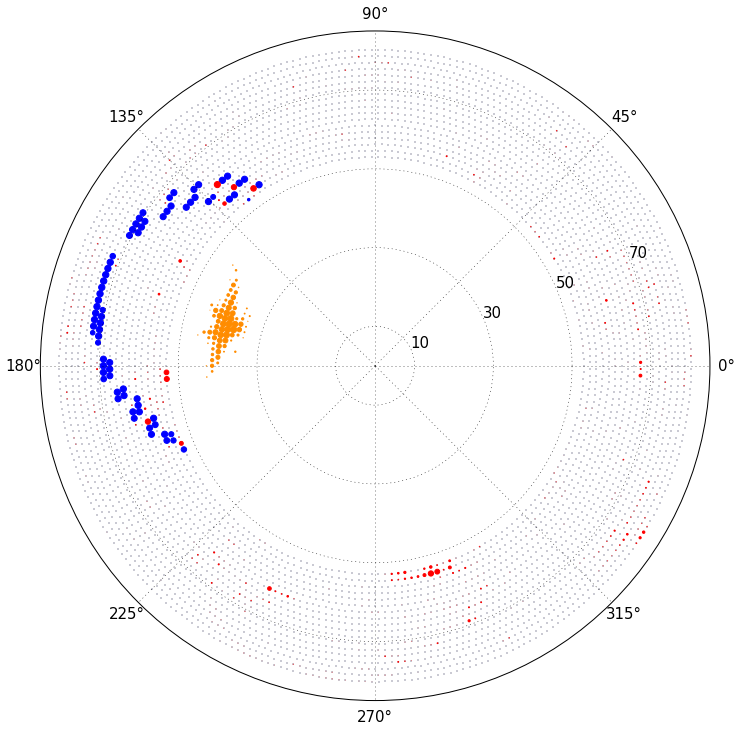

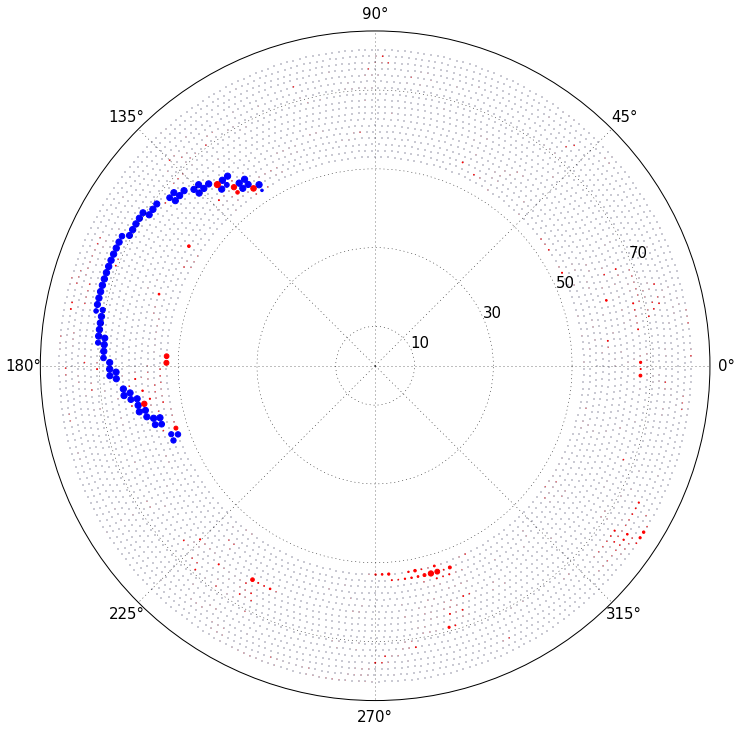

In [711]:
# Even points
plot_output(to_plot, hits.cydet, size=plot_norm_size(pred_evt_3[event,:]))
plot_add_tracks(hits.cydet, hough, size=plot_norm_size(hough_image_even,40))
show()

# Odd points
plot_output(to_plot, hits.cydet, size=plot_norm_size(pred_evt_3[event,:]))
plot_add_tracks(hits.cydet, hough, size=plot_norm_size(hough_image_odd,40))
show()

# Rotated Image
plot_output(to_plot, hits.cydet, size=plot_norm_size(pred_evt_3[event,:]), rotate_even=-ideal_phi*dphi)
show()

## Visualization of Progress of Algorithm

In [384]:
#optimize hough to improve track purity, use RANSAC to shed background islands

In [385]:
event = 3
evt_hits = event_to_hit_look[event]
to_plot = data_3["labels"].values[evt_hits]
hough_output = data_3["Hough"].values[evt_hits]
plot_hough_image_3 = hough_image_3[event,:hough.track.n_points] + hough_image_3[event,hough.track.n_points:]

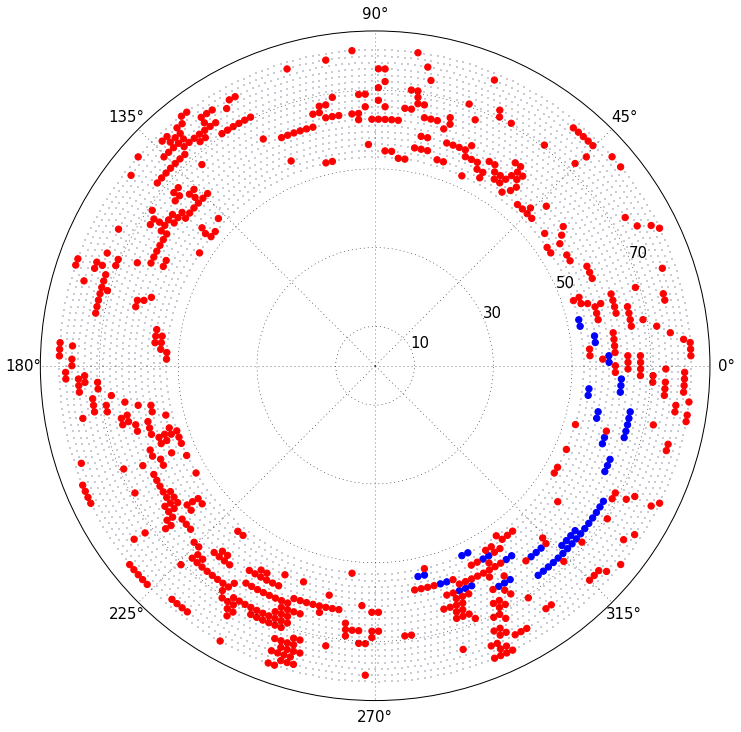

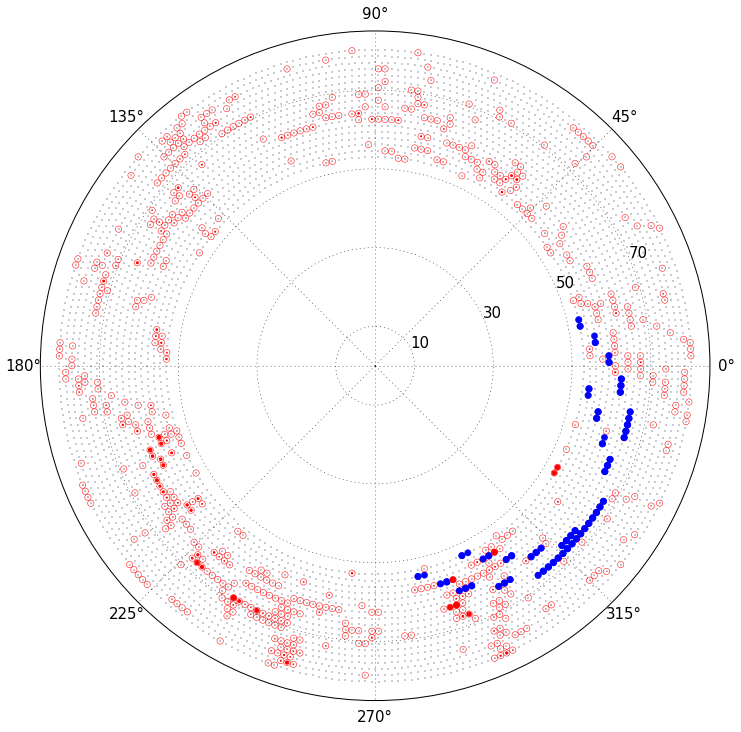

Length of draw tracks are 77


/home/elg112/.local/lib/python2.7/site-packages/IPython/kernel/__main__.py:13: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


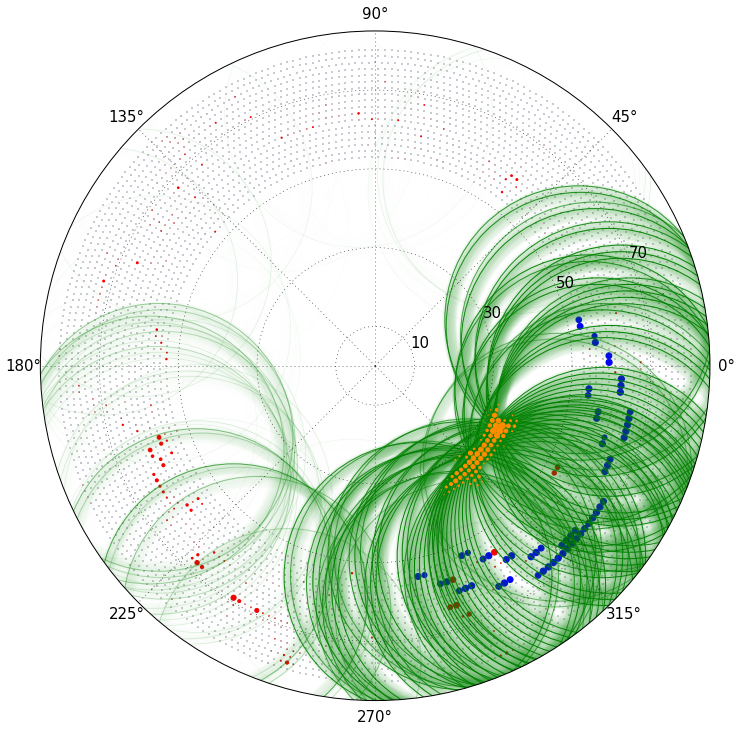

Length of draw tracks are 77


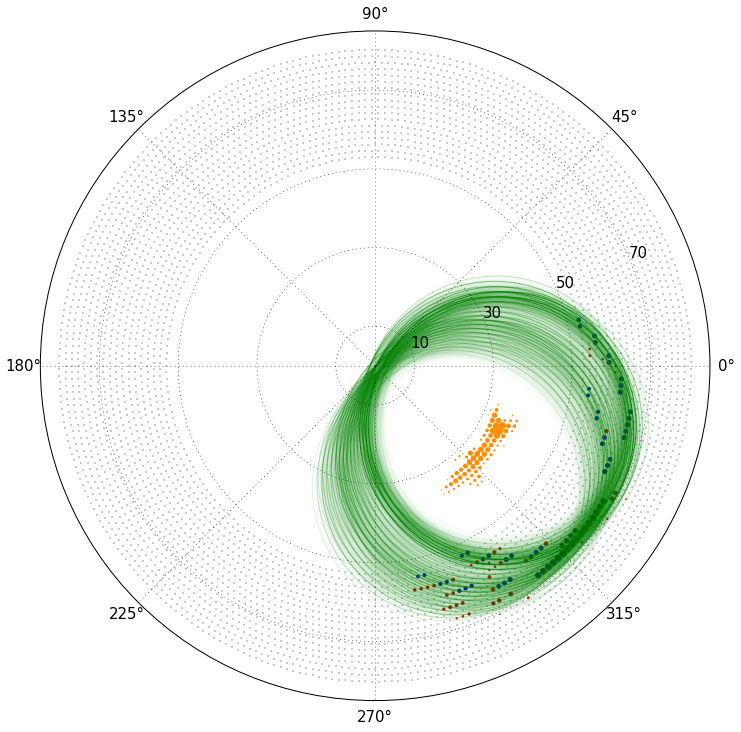

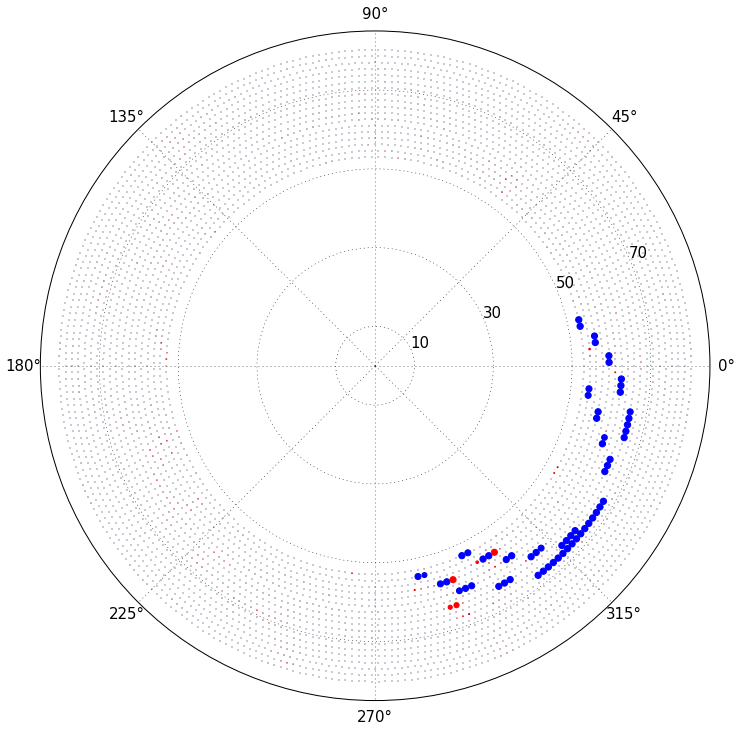

Fit:33.3547049259
RANSAC Fit:33.3547049259

Fit:33.2371778409
RANSAC Fit:32.7048627302



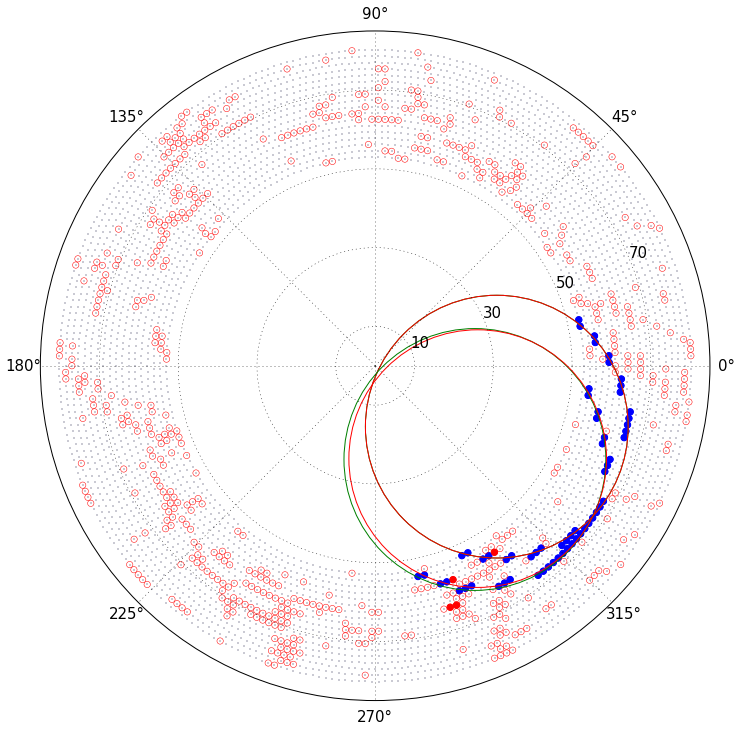

(array([ 30.88487075,  25.32343221]), array([-15.45498417, -23.79693495]), array([ 33.35470493,  33.23717784]), array([ 30.88487075,  26.0382608 ]), array([-15.45498417, -23.57267848]), array([ 33.35470493,  32.70486273]), -66)


In [146]:
# Basic output
plot_output(to_plot, hits.cydet)
show()
# First GBDT output
plot_output(to_plot, hits.cydet, size=plot_norm_size(pred_evt_3[event,:]))
plot_add_outlines(to_plot, hits.cydet)
show()
# Hough output
plot_output(to_plot, hits.cydet, size=plot_norm_size(pred_evt_3[event,:]), add_transform=True)
plot_add_tracks(hits.cydet, hough, size=plot_norm_size(plot_hough_image_3,40))
show()
# Inverse Hough output
plot_output(to_plot, hits.cydet, size=plot_norm_size(hough_output))
plot_add_tracks(hits.cydet, hough, size=plot_norm_size(plot_hough_image_3,40), add_transform=True,
                tolerance=0.00)
show()
# Final
plot_output(to_plot, hits.cydet, size=plot_norm_size(pred_final_evt_3[event,:]))
show()

# RANSAC 
print ransac_fit(to_plot, cut_pred_final_3[event,:], plot=True)